## "Predicting the probability of loan default in the peer-to-peer investement markets using loan data and text analysis"

# Importing data and all packages:

In [126]:
#General packages:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
import plotly as plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='JonathanMarin', api_key='JRrW2MSjrq4LwNVWy2Y7')
import plotly.graph_objs as go
from scipy.stats import randint as sp_randint
from pylab import rcParams
from collections import Counter
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc


#Machine learning packages:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.metrics import f1_score

#Text analysis packages:
import regex as re
from afinn import Afinn
import enchant
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob
from nltk import ne_chunk, pos_tag
from textblob.sentiments import NaiveBayesAnalyzer
from textblob import Blobber
from itertools import chain
from nltk.corpus import stopwords
#nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS

In [127]:
data = pd.read_excel("lenderclubdata_new.xlsx")

# Cleaning data for machine learning:

In [128]:
#Remove all rows in comment-column with NaN's (we resrict our analysis to loaners who have made a loan description):
df = data[pd.notnull(data['desc'])]
data1 = df.copy()

#Remove irrelevant columns 
df = df.drop(["member_id", "sub_grade", "title", "pymnt_plan", "open_acc", "addr_state", "installment", "id", "url", "issue_d", "funded_amnt", "funded_amnt_inv", "emp_title"], axis=1)

#Recode loan status:
data1['loan_status_new'] = df['loan_status'].map({'Current': 0, 'Fully Paid': 0, 'Default': 1, 'Charged Off': 1, 'In Grace Period': 0, 'Late (31-120 days)': 0, 'Late (16-30 days)': 0})
df['loan_status'] = df['loan_status'].map({'Current': 0, 'Fully Paid': 0, 'Default': 1, 'Charged Off': 1, 'In Grace Period': 0, 'Late (31-120 days)': 0, 'Late (16-30 days)': 0})

#Turn categorical/nominal/binary variables into dummys variables: 
df = pd.get_dummies(df, columns=['grade', "purpose", "home_ownership", "verification_status", "loan_status", "term"], drop_first=True)

#Remove all rows with NaN values in them: 
df = df.dropna()

#Convert continous variables:
df["int_rate"] = df.int_rate.str.strip('%') #interest rate
df["emp_length"] = df.emp_length.str.strip('years')
df["emp_length"] = df.emp_length.str.replace('+',"")
df["emp_length"] = df.emp_length.str.strip('<')
df["emp_length"] = df.emp_length.str.strip('>')

#Convert relevant columns to numeric:
df[['int_rate', 'emp_length', "annual_inc"]] = df[['int_rate', 'emp_length', "annual_inc"]].astype(float)

#Create a column with ID for rows (for later use):
df = df.reset_index()
df["index"] = df.index + 1

#Remove "desc" with id for later match. This is our "comment"-dataframe:
df_desc = df[["index", "desc"]]
#Drop desc from other dataframe:
df = df.drop(["desc"], axis=1)


# Descriptive statistics:

#### Visualization of loan data for DEFAULTERS:

Counter({0: 7447, 1: 4450})
Counter({'C': 3604, 'B': 3225, 'D': 2510, 'E': 1368, 'A': 876, 'F': 786, 'G': 209})


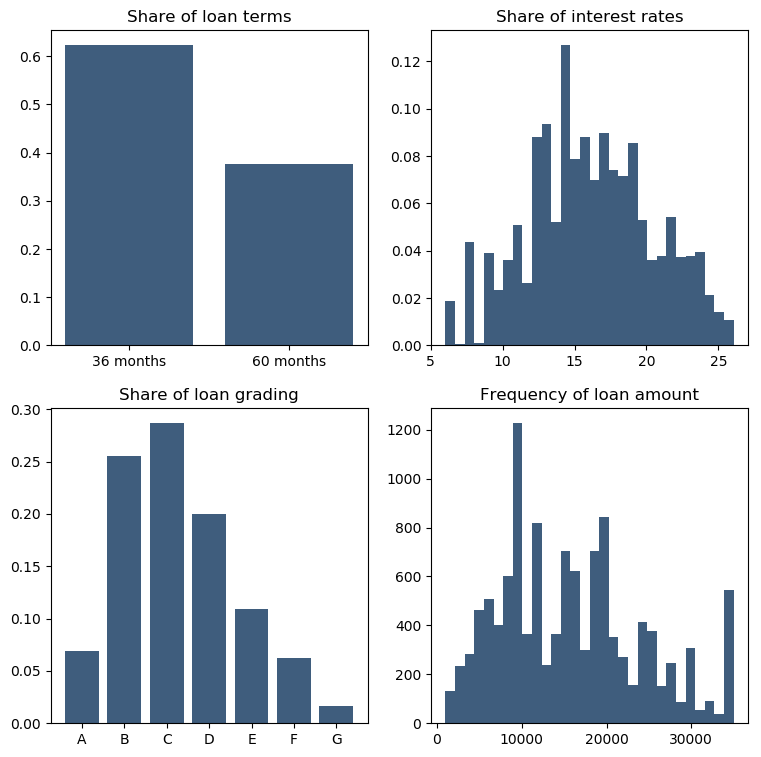

In [129]:
from pylab import figure, axes, pie, title, show
plt.style.use('default')

#subset dataframes:
df_default = df.loc[df["loan_status_1"] == 1]
df_default_grade = data1.loc[data1["loan_status_new"] == 1]

#Set subplots:
fig, axarr = plt.subplots(2, 2, figsize=(9,9))
plt.title("Data for individuals who default")

#Term of loan:
print(Counter(df_default["term_ 60 months"]))
x = ["36 months", "60 months"]
y1 = np.array([7447, 4507])
y = y1/np.sum(y1)
axarr[0, 0].bar(x, y, color="#3F5D7D")
axarr[0, 0].set_title('Share of loan terms', size=12)

#Loan ammount:
axarr[1, 1].hist(df_default["loan_amnt"], bins=30, color="#3F5D7D")
axarr[1, 1].set_title('Frequency of loan amount', size=12)

#Interest rate:
axarr[0, 1].hist(df_default["int_rate"], bins=30, color="#3F5D7D", density=True)
axarr[0, 1].set_title('Share of interest rates', size=12)

#Loan grading:
print(Counter(df_default_grade["grade"]))
k = np.array([877, 3230, 3622, 2523, 1382, 792, 212])
count_grade = k/np.sum(k)
grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
axarr[1, 0].bar(grade, count_grade, color="#3F5D7D")
axarr[1, 0].set_title('Share of loan grading', size=12)

#Save figure:
fig.savefig('default.png', bbox_inches='tight')

#### Visualization of loan data for those who pay on time:

Counter({0: 53242, 1: 12856})
Counter({'B': 25404, 'C': 16270, 'A': 14180, 'D': 8027, 'E': 3206, 'F': 1485, 'G': 328})


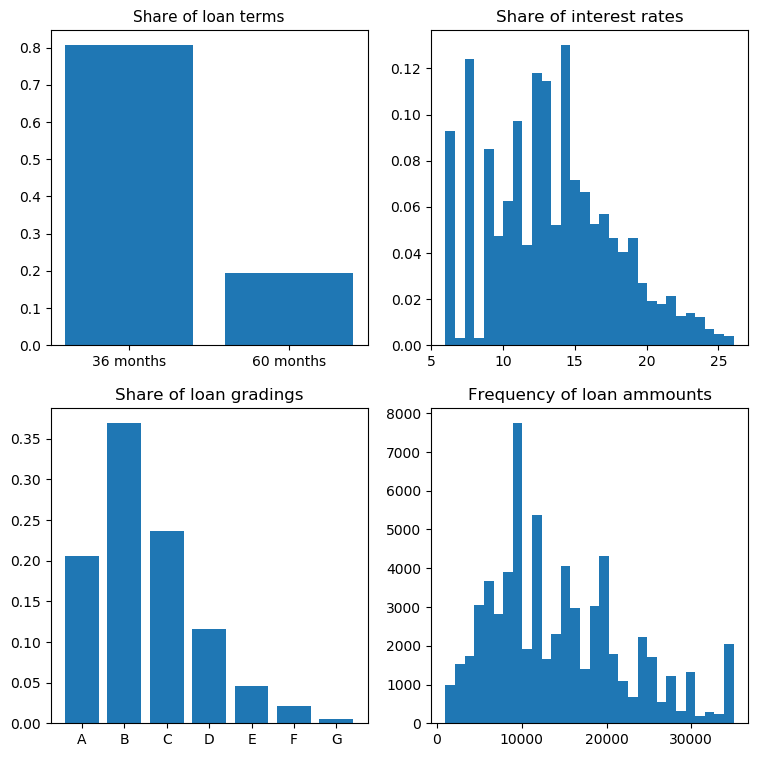

In [131]:
#subset dataframes:
df_paid = df.loc[df["loan_status_1"] == 0]
df_paid_grade = data1.loc[data1["loan_status_new"] == 0]

#Set subplots:
fig2, axarr = plt.subplots(2, 2, figsize=(9,9))

#### LOAN DATA #####
#Term of loan:
print(Counter(df_paid["term_ 60 months"]))
x = ["36 months", "60 months"]
y1 = np.array([53242, 12799])
y = y1/np.sum(y1)
axarr[0, 0].bar(x, y)
axarr[0, 0].set_title('Share of loan terms', size=11)

#Loan ammount:
axarr[1, 1].hist(df_paid["loan_amnt"], bins=30, density=False)
axarr[1, 1].set_title('Frequency of loan ammounts', size=12)

#Interest rate:
axarr[0, 1].hist(df_paid["int_rate"], bins=30, density=True)
axarr[0, 1].set_title('Share of interest rates', size=12)

#Loan grading:
print(Counter(df_paid_grade["grade"]))
k = np.array([14179, 25399, 16252, 8014, 3192, 1479, 325])
count_grade = k/np.sum(k)
grade = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
axarr[1, 0].bar(grade, count_grade)
axarr[1, 0].set_title('Share of loan gradings', size=12)

#Save figure:
fig2.savefig('paid.png', bbox_inches='tight')

# Preparing data for machine learning:

#### Create NON-normalized feature and label data:

In [153]:
X = df.drop(["loan_status_1", "index"], axis=1).values
y = df["loan_status_1"].values

#### Create NORMALIZED feature and label data:

In [133]:
#First normalize the continous variables:
df_normalized = df.copy()
df_normalized[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]] = preprocessing.normalize(df_normalized[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]])

#Create feature and label from normalized data:
X_normalized = df_normalized.drop(["loan_status_1", "index"], axis=1).values
y_normalized = df_normalized["loan_status_1"].values

#### Create downsampled data:

In [134]:
#first split into train and test:
train, test = train_test_split(df, test_size=0.3, random_state = 42)   

In [135]:
#Create feature and label from test data:
X_test = test.drop(["loan_status_1", "index"], axis=1).values
y_test = test["loan_status_1"].values

test_normalized = test.copy()
test_normalized[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]] = preprocessing.normalize(test_normalized[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]])

#Create feature and label from normalized data:
X_norm_test = test_normalized.drop(["loan_status_1", "index"], axis=1).values
y_norm_test = test_normalized["loan_status_1"].values

In [136]:
#Create downsampled da on train data:
df_balanced = train.drop(train.query('loan_status_1 < 1').sample(frac=.82, random_state=42).index)
print(Counter((df_balanced["loan_status_1"])))

X_balance = df_balanced.drop(["loan_status_1", "index"], axis=1).values
y_balance = df_balanced["loan_status_1"].values

df_normalized_balance = df_balanced.copy()
df_normalized_balance[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]] = preprocessing.normalize(df_normalized_balance[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]])

#Create feature and label from normalized data:
X_norm_balance = df_normalized_balance.drop(["loan_status_1", "index"], axis=1).values
y_norm_balance = df_normalized_balance["loan_status_1"].values

Counter({1: 8329, 0: 8328})


# Running machine learning models on loan-level data:

We are dealing with a classification problem since we are trying to predict a binary outcome (and the probability of this outcome).
Hence, all of the chosen models are classifiers

##### Define function for running and scoring models

In [137]:
def prediction_model(splits, model, X, y):
    
    #Set hyperparameters and empty vectors:
    kf = KFold(n_splits=int(splits), random_state=42)
    accuracy = []
    train_acc = []
    precision = []
    recall = []
    f1 = []
    train = []
    y_prob = []
    

    #Setup cross validation loop:
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]    
    
        model.fit(X_train, y_train) 
    
        y_pred = model.predict(X_train)
        train_acc.append(accuracy_score(y_train, y_pred))

        y_pred1 = model.predict(X_test)
        f1.append(f1_score(y_test, y_pred1))
        accuracy.append(accuracy_score(y_test, y_pred1))
        precision.append(precision_score(y_test, y_pred1))
        recall.append(recall_score(y_test, y_pred1))

    #Print the mean accuracy score across all 10 kfolds:
    print("Training accuracy score", np.mean(train_acc))
    print("Accuracy score", np.mean(accuracy))
    print("Precision score", np.mean(precision))
    print("Recall score", np.mean(recall))
    print("F1 score", np.mean(f1))

##### Define function for computing area under curve (numeric as well as visually)

In [138]:
def area_under_curve(splits, model, X, y):
    
    kf = KFold(n_splits=int(splits), random_state=42)  
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in kf.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## K-nearest neighbour classifier:

##### Finding optimal hyperparameters through gridsearch for entire dataset

In [ ]:
# Perform a grid-search to find the optimal number of neighbours
model = KNeighborsClassifier()
k_range = list(range(1, 15))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=3, scoring='recall')
grid.fit(X_normalized, y_normalized)
print(grid.best_params_)

##### Finding optimal hyperparameters through gridsearch for downsampled dataset


In [ ]:
# Perform a grid-search to find the optimal number of neighbours:
model = KNeighborsClassifier()
k_range = list(range(1, 15))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=3, scoring='recall')
grid.fit(X_norm_balance, y_norm_balance)
print(grid.best_params_)

##### Training and evaluating KNN on entire dataset

In [156]:
model = KNeighborsClassifier(n_neighbors=5)
prediction_model(10,model,X_normalized, y_normalized)

Training accuracy score 0.8610922317696665
Accuracy score 0.827065573824389
Precision score 0.2827782514935693
Recall score 0.08821927921705408
F1 score 0.13411139910783362


##### Training and evaluating KNN on downsampled dataset

In [157]:
model = KNeighborsClassifier(n_neighbors=11)
model.fit(X_norm_balance, y_norm_balance)
y_pred = model.predict(X_norm_test)
print(f1_score(y_norm_test, y_pred))
print(accuracy_score(y_norm_test, y_pred))
print(precision_score(y_norm_test, y_pred))
print(recall_score(y_norm_test, y_pred))

0.3156324582338902
0.6078464891662037
0.21504065040650405
0.5930493273542601


## Random forest classifier:

##### Finding optimal hyperparameters through gridsearch for entire dataset

In [150]:
# Finding best hyperparameters through grid-search:
# specify parameters and distributions to sample from_
clf = RandomForestClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run randomized search
random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, cv=3, n_iter = 100, scoring="recall")

# Report best parameters
random_search.fit(X, y)
random_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 4}

##### Finding optimal hyperparameters through gridsearch for downsampled dataset

In [151]:
# Finding best hyperparameters through grid-search:
# specify parameters and distributions to sample from_
clf = RandomForestClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, cv=3, n_iter = 100, scoring="recall")

#Report best parameters
random_search.fit(X_balance, y_balance)
random_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

##### Training and evaluting model on entire dataset

In [154]:
model = RandomForestClassifier(max_depth = None, max_features = 10, min_samples_leaf = 2, bootstrap = False, 
                               min_samples_split = 4, criterion = "entropy")

prediction_model(10, model, X, y)

Training accuracy score 0.9988731467635533
Accuracy score 0.8359379736389609
Precision score 0.30149494407031985
Recall score 0.05846764875124503
F1 score 0.09767449922655627


##### Training and evaluting model on downsampled dataset

In [155]:
model = RandomForestClassifier(max_depth = 3, max_features = 10, min_samples_leaf = 4, bootstrap = False, 
                               min_samples_split = 10, criterion = "entropy", n_estimators=500)

model.fit(X_balance, y_balance)
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.33284096504185134
0.5946407966152399
0.22218048643065078
0.6631165919282511


## Logistic regression:

##### Finding optimal hyperparameters through gridsearch for entire dataset

In [148]:
# Perform a grid-search to find the optimal number for C:
model = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid = GridSearchCV(model, hyperparameters, cv=3, scoring='recall')
grid.fit(X_normalized, y_normalized)
print(grid.best_params_)

{'C': 10000.0, 'penalty': 'l1'}


##### Finding optimal hyperparameters through gridsearch for downsampled dataset

In [146]:
#We perform a grid-search to find the optimal number for C:
model = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid = GridSearchCV(model, hyperparameters, cv=3, scoring='recall')
grid.fit(X_norm_balance, y_norm_balance)
print(grid.best_params_)

{'C': 1.0, 'penalty': 'l1'}


##### Training and evaluating model for entire dataset

In [149]:
model = LogisticRegression(penalty="l1", C=10000)
prediction_model(10,model,X_normalized, y_normalized)

Training accuracy score 0.8470457478353598
Accuracy score 0.8468232794473979
Precision score 0.3747928007235283
Recall score 0.004653102875619755
F1 score 0.009168446073485981


##### Training and evaluating model for downsampled dataset

In [147]:
model = LogisticRegression(penalty="l1", C=1)
model.fit(X_norm_balance, y_norm_balance)
y_pred = model.predict(X_norm_test)
print(f1_score(y_norm_test, y_pred))
print(accuracy_score(y_norm_test, y_pred))
print(precision_score(y_norm_test, y_pred))
print(recall_score(y_norm_test, y_pred))

0.3386243386243386
0.6207102867643917
0.2306364836057253
0.6367713004484304


# Text analysis and feature engineering:

#### Cleaning text data:

In [107]:
#Remove automatically produced text at the beginning of each text:
text = []
for i in df_desc["desc"]:
    i = re.sub(r'\d+.','', i)
    head, sep, tail = i.partition('>')
    text.append(tail)

#Remove all automatically generated sentence endings andmore: 
text = [item.replace(r'.<br>.|\s<br>', '') for item in text]
text = [item.replace(r'<br><br>', '') for item in text]
text = [item.replace('Borrower added on ', '') for item in text]
text = [item.replace('>', '') for item in text]
text = [item.replace('-', '') for item in text]
text = [item.replace('!', '') for item in text]
text = [item.replace('?', '') for item in text]
text = [item.replace('(', '') for item in text]
text = [item.replace(')', '') for item in text]
text = [item.replace('<br', '') for item in text]
text = [item.replace('//', '') for item in text]

#We remove punctuation as the following functions are sensitive to those
text = [item.replace(',', '') for item in text]
text = [item.replace('.', '') for item in text]

#Replace cleaned text with existing text column:
df_desc["desc"] = pd.DataFrame(text)

## Descriptive analysis of texts:

##### Occurences of words:
Visualizing the most commonly mentioned words:

In [6]:
# Concatenate all text into one list with words split up
all_words = df_desc["desc"].str.split()
all_words = list(chain(*all_words))

# Turn all words to lower to avoid double counting words:
all_words = [word.lower() for word in all_words]

# Remove stopwords as these are of no analytical value:
all_words_filtered = [word for word in all_words if word not in stopwords.words('english')]

# Count frequencies of words:
all_words_filtered = pd.Series(all_words_filtered)
all_words_filtered = all_words_filtered.value_counts() #finds frequencies of words and lists them in descending order

# Plot the top 50 most mentioned words:
data = [go.Bar(
            x = all_words_filtered.index.values[0:50],
            y = all_words_filtered.values[0:50],
            marker= dict(colorscale='Jet', color = all_words_filtered.values[2:100]), text='Word counts')]

layout = go.Layout(title='Word frequencies in the dataset')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

It is interesting to see whether there are differences in which words are used morre commonly between those who default on their loans and those who do not. We can use barcharts of word frequencies (as the one above) as well as wordclouds:

#### Wordcloud function for those who defaults and thos who pays on time:

In [7]:
#First define function to make wordcloud:
def word_cloud(k):
    #Split data
    df_desc["default"] = df["loan_status_1"]
    dataframe = df_desc.loc[df_desc["default"] == int(k)]
    
    #Format text
    all_words = list(df_desc["desc"])
    all_words = ''.join(map(str, all_words))
    
    stopwords = set(STOPWORDS)
    
    #Generate a word cloud image 
    wc = WordCloud(background_color="white", stopwords=stopwords, collocations=False, 
                   max_words=300, width=1000, height=600)
    
    #Generate plot
    wordcloud = wc.generate(all_words)
    plt.figure(figsize=(15,15))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
    return(plt.show)

#### Good payers:

<function matplotlib.pyplot.show>

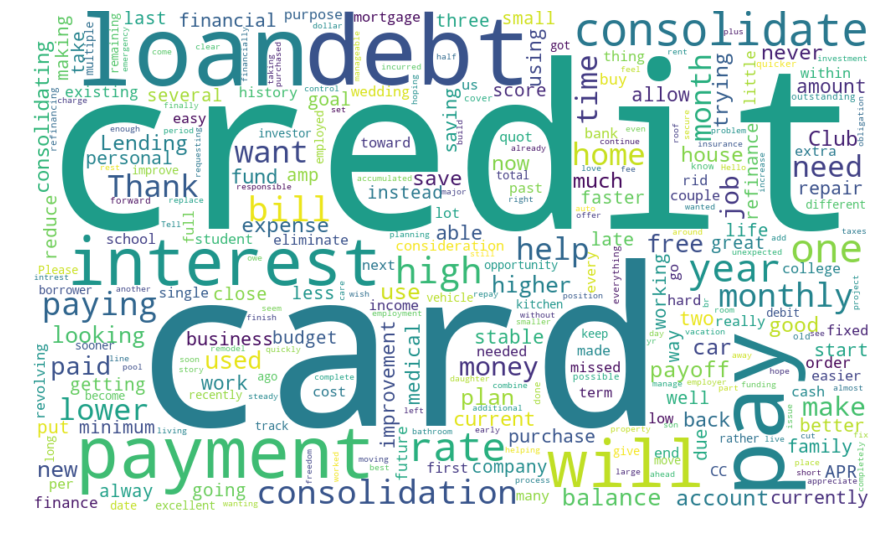

In [8]:
word_cloud(0)

#### Bad payers:

<function matplotlib.pyplot.show>

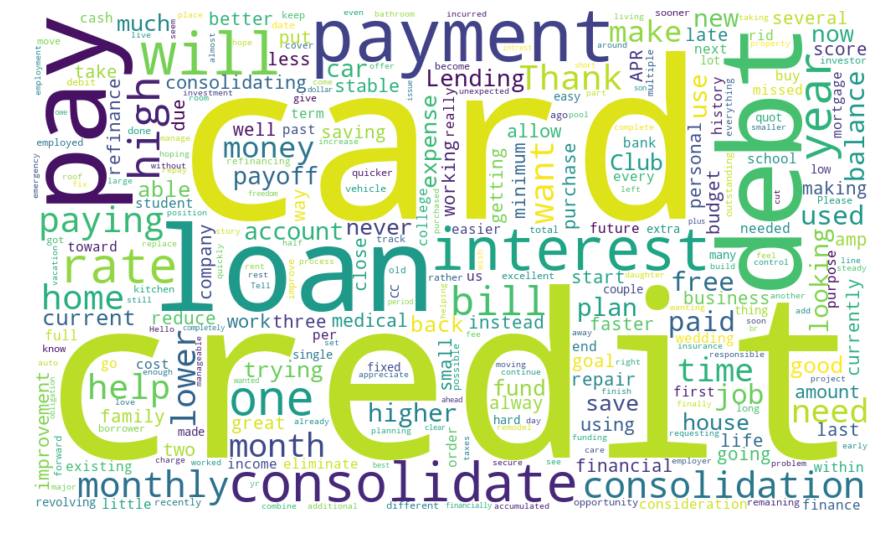

In [9]:
word_cloud(1)

# Extracing features from text:

##### Start by using Afinn to calculate sentiment scores:

In [108]:
#Initialize afinn package:
afinn = Afinn()

#Calculate afinn_scores for all texts:
score = []
for i in text: 
    score.append(afinn.score(i)) #Afinn produces numeric "scores" that are either positive or negative.

#Add sentiment scores to dataframe:
df_desc["sentiment"] = pd.DataFrame(score)

##### Using TextBlob to calculate subjectivity scores:

In [109]:
#Calculating subjectivity scores:
subjectivity_score = []

for i in text: 
    blob = TextBlob(i)
    subjectivity_score.append(blob.sentiment.subjectivity)
    
#Add subjectivity scores to dataframe:
df_desc["subjectivity"] = pd.DataFrame(subjectivity_score)

### Spelling errors:

In [110]:
#Initializing the enchant-package which can check a given word for spelling error.
d = enchant.Dict("en_US")

#Initializing tokenizer function:
tokenizer = treebank.TreebankWordTokenizer()

def spelling_error_count(text):
    #A function that checks each word in a sentence for a spelling error and returns the number of spelling errors in that sentence
    #This function is very sensititive to characters such as "!" or "?". Therefore they have been remove earlier.
    #I use the TweetTokenzier because it handles words with apostrophes well.
    tokenizer = TweetTokenizer()
    tokenized_words = tokenizer.tokenize(text)
    _sum = 0
    for i in tokenized_words:
        i = d.check(i)
        if i == False:
            _sum += 1
    return(_sum)

#Calcluate spelling errors for each text in data and storing it in an object:
spelling_errors=[]
for i in text:
    spelling_errors.append(spelling_error_count(i))
    
#Add spelling_error_count  to dataframe:
df_desc["spelling_error"] = pd.DataFrame(spelling_errors)

### Length of text:

In [111]:
#Defining a function that count number of words in a text:
def word_count(text):
    count = len(re.findall(r'\w+', text))
    return(count)

#Loop this function over the data set 
word_counts=[]
for i in text:
    word_counts.append(word_count(i))
    
#Add spelling_error_count  to dataframe:
df_desc["word_count"] = pd.DataFrame(word_counts)

### Prevalance of pronouns:

In [112]:
def process_content(text):
    #Tokenized each description and find POS-tags
    k = pos_tag(word_tokenize(text))
    return(k)

#Calculate ratio of pronouns to all words for each loan description:
pronouns= []

#Loop function through all loan descriptions:
for v in df_desc["desc"]:
    k = process_content(v)
    pronoun_list = ['PRP', 'PRP$']
    num_pronouns = 0
    for i, p in k:
        if p in pronoun_list:
            num_pronouns += 1
    pronouns.append(num_pronouns)

#Add spelling_error_count  to dataframe:
df_desc["pronouns"] = pd.DataFrame(pronouns)

### Descriptive stats of text features:

In [114]:
df_desc["default"] = df["loan_status_1"]

def desc_stats(column):
    #This is a function to calculate descriptive stats for defaulters/non-defaulters
    #for the various text features
    
    print("Bad payers:")
    df_default = df_desc.loc[df_desc["default"] == 1]
    print("mean", np.mean(df_default[str(column)]))
    print("std", np.std(df_default[str(column)]))
    print("min", np.amin(df_default[str(column)]))
    print("max", np.amax(df_default[str(column)]))
    
    print("Good payers:")
    df_pay = df_desc.loc[df_desc["default"] == 0]
    print("mean", np.mean(df_pay[str(column)]))
    print("std", np.std(df_pay[str(column)]))
    print("min", np.amin(df_pay[str(column)]))
    print("max", np.amax(df_pay[str(column)]))

# Implementing text features into machine learning models

##### Include text data in loan-data:

In [116]:
final_data = pd.merge(df, df_desc, on="index")
final_data.drop(['desc', "default"], axis=1, inplace=True)

In [118]:
#first split into train and test:
train, test = train_test_split(final_data, test_size=0.3, random_state = 42)

#Create feature and label from test data:
X_test = test.drop(["loan_status_1", "index"], axis=1).values
y_test = test["loan_status_1"].values

test_normalized = test.copy()
test_normalized[["loan_amnt", "pronouns", "word_count", "sentiment", "subjectivity", "spelling_error", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]] = preprocessing.normalize(test_normalized[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc", "word_count", "pronouns", "sentiment", "subjectivity", "spelling_error"]])

#Create feature and label from normalized data:
X_norm_test = test_normalized.drop(["loan_status_1", "index"], axis=1).values
y_norm_test = test_normalized["loan_status_1"].values

#Create downsampled data on train data:
df_balanced = train.drop(train.query('loan_status_1 < 1').sample(frac=.82, random_state=42).index)
print(Counter((df_balanced["loan_status_1"])))

X_balance = df_balanced.drop(["loan_status_1", "index"], axis=1).values
y_balance = df_balanced["loan_status_1"].values

df_normalized_balance = df_balanced.copy()
df_normalized_balance[["loan_amnt", "pronouns", "word_count", "sentiment", "subjectivity", "spelling_error", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc"]] = preprocessing.normalize(df_normalized_balance[["loan_amnt", "int_rate", "emp_length", "annual_inc", "inq_last_6mths", "revol_bal", "total_acc", "pronouns", "word_count", "sentiment", "subjectivity", "spelling_error"]])

#Create feature and label from normalized data:
X_norm_balance = df_normalized_balance.drop(["loan_status_1", "index"], axis=1).values
y_norm_balance = df_normalized_balance["loan_status_1"].values

Counter({1: 8329, 0: 8328})


## KNN-neighbor

##### Perform gridsearch to find hyperparameters

In [120]:
# Perform a grid-search to find the optimal number of neighbours:
model = KNeighborsClassifier()
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=10, scoring='recall')
grid.fit(X_norm_balance, y_norm_balance)
print(grid.best_params_)

{'n_neighbors': 19}


##### Train and evaluate model

In [121]:
model = KNeighborsClassifier(n_neighbors=19)
model.fit(X_norm_balance, y_norm_balance)
y_pred = model.predict(X_norm_test)
print(f1_score(y_norm_test, y_pred))
print(accuracy_score(y_norm_test, y_pred))
print(precision_score(y_norm_test, y_pred))
print(recall_score(y_norm_test, y_pred))

0.3210062514122166
0.6147271250908158
0.21948707384900606
0.5972533632286996


## Random Forest

##### Perform gridsearch to find hyperparameters

In [122]:
#Finding best hyperparameters through grid-search:
# specify parameters and distributions to sample from_
clf = RandomForestClassifier()

param_dist = {"max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              "max_features": ['auto', 'sqrt'],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 2, 4],
              "criterion": ["gini", "entropy"],
              "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400]}

# run randomized search
random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_dist, cv=3, n_iter = 2, scoring="recall")

#Report best parameters
random_search.fit(X_balance, y_balance)
random_search.best_params_

{'criterion': 'gini',
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 1000}

##### Train and evaluate model

In [123]:
model = RandomForestClassifier(max_depth = 70, max_features = "sqrt", min_samples_leaf = 3, bootstrap = False, 
                               min_samples_split = 4, criterion = "gini", n_estimators=1000)

model.fit(X_balance, y_balance)
y_pred = model.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.34003275271698674
0.6210949185862644
0.23150212852219745
0.6401345291479821


## Logistic regression:

##### Perform gridsearch to find hyperparameters

In [124]:
# Perform a grid-search to find the optimal number for C:
model = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid = GridSearchCV(model, hyperparameters, cv=3, scoring='recall')
grid.fit(X_norm_balance, y_norm_balance)
print(grid.best_params_)

{'C': 1.0, 'penalty': 'l1'}


##### Train and evaluate model

In [125]:
model = LogisticRegression(penalty="l1", C=1)
model.fit(X_norm_balance, y_norm_balance)
y_pred = model.predict(X_norm_test)
print(f1_score(y_norm_test, y_pred))
print(accuracy_score(y_norm_test, y_pred))
print(precision_score(y_norm_test, y_pred))
print(recall_score(y_norm_test, y_pred))

0.3385991058122206
0.6206675498952947
0.23061307348761673
0.6367713004484304
